# Авто-важности для solo аплифт - моделей

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold

import xgboost as xgb

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import SentColumns, CatBoostEncoder, AutoTrees, base_pipe
from autobinary import uplift_by_percentile, plot_uplift_by_percentile
from autobinary import SoloModel, ClassTransformation
from autobinary import get_uplift

In [4]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab

print('sklearn: ', sk.__version__)
print('xgboost: ', xgb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

sklearn:  0.24.2
xgboost:  1.5.2
matplotlib:  3.1.0
autobinary:  1.0.4


# 1. Загрузим данные

In [5]:
sample = pd.read_excel('../data/sample_uplift.xlsx')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (100000, 14)


f0         f1        f2        f3         f4        f5        f6  \
0  24.378650  10.059654  8.214383  4.679882  10.280525  4.115453 -1.288207   
1  12.616365  10.059654  8.890711  4.679882  10.280525  4.115453  0.294443   

         f7        f8         f9       f10       f11  treatment  target  
0  4.833815  3.971858  13.190056  5.300375 -0.168679          1       0  
1  4.833815  3.943716  13.190056  5.300375 -0.168679          0       0

In [6]:
kk = get_uplift(sample)

treatment_rate:  0.04813
control_rate:  0.03782
absolute_uplift:  0.01031


In [7]:
kk

target  treatment  count
0       0          0  14427
2       1          0    567
1       0          1  80915
3       1          1   4091

# 2. Разделим на train и test

In [8]:
sample['strat'] = sample['target'].astype(str)+'_'+sample['treatment'].astype(str)

X_train, X_val = train_test_split(
    sample,
    stratify=sample['strat'],
    test_size=0.3,
    random_state=31
)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

In [9]:
target = 'target'
treatment = 'treatment'

In [10]:
num_columns = [
    'f0', 'f1', 'f2', 'f3', 'f4', 
    'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']

prep_pipe = base_pipe(
    num_columns=num_columns, 
    kind='num')

In [11]:
params = {
    'eta':0.01,
    'n_estimators':1000,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'max_depth':6,
    'objective':'binary:logistic',
    'use_label_encoder':False,
    'n_jobs':-1,
    'random_state':42}

fit_params = {
    'early_stopping_rounds':200, 
    'eval_metric':['logloss', 'aucpr', 'auc'],
    'verbose':50}

# создаем экземпляр класса XGBClassifier
xgb_model = xgb.XGBClassifier(**params)

# задаем стратегию проверки
strat = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

# 3. SoloModel - solo_dummy

## 3.1 Считаем важности uplift модели

In [12]:
model = AutoTrees(
    main_estimator=xgb_model, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns,
    
    X_train=X_train[num_columns],
    y_train=X_train[target],
    treatment=X_train[treatment],
    
    model_type='xgboost',
    main_metric='gini',
    uplift='solo_dummy')

In [13]:
model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[0]	validation_0-logloss:0.68448	validation_0-aucpr:0.45496	validation_0-auc:0.91623	validation_1-logloss:0.68450	validation_1-aucpr:0.41646	validation_1-auc:0.92264
[50]	validation_0-logloss:0.39701	validation_0-aucpr:0.56042	validation_0-auc:0.94838	validation_1-logloss:0.39863	validation_1-aucpr:0.50138	validation_1-auc:0.94932
[100]	validation_0-logloss:0.26100	validation_0-aucpr:0.57086	validation_0-auc:0.94958	validation_1-logloss:0.26388	validation_1-aucpr:0.50064	validation_1-auc:0.94936
[150]	validation_0-logloss:0.18915	validation_0-aucpr:0.57781	validation_0-auc:0.95037	validation_1-logloss:0.19287	validation_1-aucpr:0.50143	validation_1-auc:0.94954
[200]	validation_0-logloss:0.14896	validation_0-aucpr:0.58430	validation_0-auc:0.95151	validation_1-logloss:0.15349	validation_1-aucpr:0.50145	validation_1-auc:0.94961
[250]	validation_0-logloss:0.12599	validation_0-aucpr:0.58955	validation_0-auc:0.95269	validation_1-log

1it [00:13, 13.59s/it]

BEST ITERATION:  369
gini на обучающей выборке: 91.040
gini на проверочной выборке: 90.001

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[0]	validation_0-logloss:0.68446	validation_0-aucpr:0.46415	validation_0-auc:0.91872	validation_1-logloss:0.68451	validation_1-aucpr:0.38009	validation_1-auc:0.91596
[50]	validation_0-logloss:0.39693	validation_0-aucpr:0.56281	validation_0-auc:0.94929	validation_1-logloss:0.39849	validation_1-aucpr:0.49320	validation_1-auc:0.94196
[100]	validation_0-logloss:0.26091	validation_0-aucpr:0.57052	validation_0-auc:0.95018	validation_1-logloss:0.26380	validation_1-aucpr:0.49557	validation_1-auc:0.94280
[150]	validation_0-logloss:0.18896	validation_0-aucpr:0.57704	validation_0-auc:0.95140	validation_1-logloss:0.19304	validation_1-aucpr:0.49632	validation_1-auc:0.94424
[200]	validation_0-logloss:0.14871	validation_0-aucpr:0.58325	validation_0-auc:0.95233	validation_1-logloss:

2it [00:26, 12.96s/it]

BEST ITERATION:  279
gini на обучающей выборке: 90.756
gini на проверочной выборке: 88.983

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[0]	validation_0-logloss:0.68447	validation_0-aucpr:0.46274	validation_0-auc:0.91917	validation_1-logloss:0.68451	validation_1-aucpr:0.39710	validation_1-auc:0.90990
[50]	validation_0-logloss:0.39682	validation_0-aucpr:0.56813	validation_0-auc:0.94968	validation_1-logloss:0.39840	validation_1-aucpr:0.49001	validation_1-auc:0.94126
[100]	validation_0-logloss:0.26081	validation_0-aucpr:0.57438	validation_0-auc:0.95078	validation_1-logloss:0.26363	validation_1-aucpr:0.49111	validation_1-auc:0.94178
[150]	validation_0-logloss:0.18887	validation_0-aucpr:0.58007	validation_0-auc:0.95180	validation_1-logloss:0.19287	validation_1-aucpr:0.48971	validation_1-auc:0.94224
[200]	validation_0-logloss:0.14862	validation_0-aucpr:0.58596	validation_0-auc:0.95270	validation_1-logloss:

3it [00:47, 16.96s/it]

gini на обучающей выборке: 92.056
gini на проверочной выборке: 88.786

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[0]	validation_0-logloss:0.68448	validation_0-aucpr:0.45285	validation_0-auc:0.90284	validation_1-logloss:0.68449	validation_1-aucpr:0.42122	validation_1-auc:0.90531
[50]	validation_0-logloss:0.39690	validation_0-aucpr:0.56640	validation_0-auc:0.94945	validation_1-logloss:0.39841	validation_1-aucpr:0.49406	validation_1-auc:0.94392
[100]	validation_0-logloss:0.26092	validation_0-aucpr:0.57316	validation_0-auc:0.95053	validation_1-logloss:0.26360	validation_1-aucpr:0.49684	validation_1-auc:0.94405
[150]	validation_0-logloss:0.18904	validation_0-aucpr:0.57944	validation_0-auc:0.95179	validation_1-logloss:0.19266	validation_1-aucpr:0.50007	validation_1-auc:0.94415
[200]	validation_0-logloss:0.14881	validation_0-aucpr:0.58481	validation_0-auc:0.95280	validation_1-logloss:0.15339	validation_1-

4it [01:00, 15.32s/it]

BEST ITERATION:  259
gini на обучающей выборке: 90.790
gini на проверочной выборке: 88.858

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[0]	validation_0-logloss:0.68448	validation_0-aucpr:0.45898	validation_0-auc:0.90733	validation_1-logloss:0.68451	validation_1-aucpr:0.37480	validation_1-auc:0.88839
[50]	validation_0-logloss:0.39671	validation_0-aucpr:0.56666	validation_0-auc:0.95051	validation_1-logloss:0.39849	validation_1-aucpr:0.48728	validation_1-auc:0.93785
[100]	validation_0-logloss:0.26055	validation_0-aucpr:0.57327	validation_0-auc:0.95153	validation_1-logloss:0.26409	validation_1-aucpr:0.48866	validation_1-auc:0.93817
[150]	validation_0-logloss:0.18847	validation_0-aucpr:0.58045	validation_0-auc:0.95267	validation_1-logloss:0.19377	validation_1-aucpr:0.48947	validation_1-auc:0.93795
[200]	validation_0-logloss:0.14810	validation_0-aucpr:0.58652	validation_0-auc:0.95371	validation_1-logloss:

5it [01:19, 15.85s/it]

gini на обучающей выборке: 91.655
gini на проверочной выборке: 87.940

********************** 5 фолд обучен! ******************************




In [14]:
model.get_mean_cv_scores()

88.9137891450185

In [15]:
model._best_iters

[369, 279, 615, 259, 433]

In [16]:
model.get_extra_scores()

names     fold_1     fold_2     fold_3     fold_4     fold_5
0   roc_train   0.955202   0.953778   0.960280   0.953951   0.958277
1   roc_valid   0.950006   0.944916   0.943931   0.944292   0.939701
2  gini_train  91.040339  90.755530  92.055976  90.790298  91.655475
3  gini_valid  90.001156  88.983127  88.786147  88.858341  87.940175

In [17]:
fi = model.get_fi()
fi

index  importance 0  importance 1  importance 2  importance 3  \
0          f9     48.474403     47.084599     51.441616     46.515636   
1          f8     42.127926     50.143993     28.199888     50.983952   
2          f2     11.004297     12.433038      8.879724     12.282305   
3          f4      3.389467      6.300235      4.392391      4.845556   
4         f10      4.307870      4.177564      3.337126      3.748661   
5         f11      3.875951      3.863418      3.501401      3.532948   
6          f6      3.445550      3.605415      3.191415      3.474749   
7          f3      3.147119      3.217377      2.982352      3.558948   
8          f0      3.031204      3.428114      2.919280      3.390721   
9   treatment      3.287431      3.587490      2.997203      3.020020   
10         f7      2.763579      3.080122      3.184563      2.627216   
11         f1      2.276010      2.572286      2.204406      1.971728   
12         f5      1.754780      2.139243      2.166795      1.947984   

    importance 4  mean_importance  
0      54.230000        49.549251  
1      37.487335        41.788619  
2      10.362071        10.992287  
3       2.963554         4.378241  
4       3.978364         3.909917  
5       3.316272         3.617998  
6       3.282382         3.399902  
7       3.075458         3.196251  
8       2.841655         3.122195  
9       2.628740         3.104177  
10      2.488571         2.828810  
11      3.310254         2.466937  
12      2.294815         2.060723

In [18]:
model.get_curve_plots()

## 3.2 Построим модель с подобранными итерациями

In [19]:
params = {
    'eta':0.01*2,
    'n_estimators':round(np.mean(model._best_iters)/0.85),
    'subsample':0.8,
    'colsample_bytree':0.8,
    'max_depth':6,
    'objective':'binary:logistic',
    'use_label_encoder':False,
    'n_jobs':-1,
    'random_state':42}

estimator = xgb.XGBClassifier(**params)
slearner = SoloModel(estimator, method='dummy')

In [20]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    kind='num')

prep_pipe.fit(X_train[num_columns], X_train[target])

new_X_train = prep_pipe.transform(X_train[num_columns])
new_X_val = prep_pipe.transform(X_val[num_columns])

In [21]:
slearner = slearner.fit(new_X_train, X_train[target], X_train[treatment])

scores = slearner.predict(new_X_val)

[13:17:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## 3.3 Результат на тесте

In [22]:
uplift_by_percentile(
    X_val[target], 
    scores, 
    X_val[treatment], 
    strategy='overall', 
    total=True, 
    std=True, 
    bins=10)

n_treatment  n_control  response_rate_treatment  \
percentile                                                    
0-10               2562        438                 0.309914   
10-20              2520        480                 0.091270   
20-30              2578        422                 0.022110   
30-40              2533        467                 0.008291   
40-50              2551        449                 0.011368   
50-60              2527        473                 0.001583   
60-70              2538        462                 0.000394   
70-80              2528        472                 0.001978   
80-90              2590        410                 0.001544   
90-100             2575        425                 0.031845   
total             25502       4498                 0.048114   

            response_rate_control    uplift  std_treatment  std_control  \
percentile                                                                
0-10                     0.294521  0.015394       0.009137     0.021780   
10-20                    0.056250  0.035020       0.005737     0.010516   
20-30                    0.009479  0.012631       0.002896     0.004717   
30-40                    0.008565 -0.000275       0.001802     0.004264   
40-50                    0.002227  0.009141       0.002099     0.002225   
50-60                    0.002114 -0.000531       0.000791     0.002112   
60-70                    0.000000  0.000394       0.000394     0.000000   
70-80                    0.002119 -0.000141       0.000884     0.002116   
80-90                    0.002439 -0.000895       0.000772     0.002436   
90-100                   0.004706  0.027139       0.003460     0.003320   
total                    0.037795  0.010319       0.027970     0.053487   

            std_uplift  
percentile              
0-10          0.023619  
10-20         0.011979  
20-30         0.005535  
30-40         0.004629  
40-50         0.003059  
50-60         0.002255  
60-70         0.000394  
70-80         0.002293  
80-90         0.002555  
90-100        0.004795  
total         0.061114

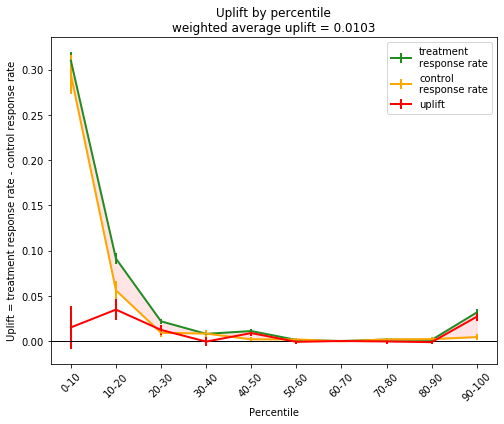

In [23]:
# line plot
plot_uplift_by_percentile(
    X_val[target], 
    scores, 
    X_val[treatment],
    strategy='overall', 
    kind='line');

# 4. SoloModel - solo_interaction

## 4.1 Считаем важности uplift модели

In [24]:
model = AutoTrees(
    main_estimator=xgb_model, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns,
    
    X_train=X_train[num_columns],
    y_train=X_train[target],
    treatment=X_train[treatment],
    
    model_type='xgboost',
    main_metric='gini',
    uplift='solo_interaction')

In [25]:
model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[0]	validation_0-logloss:0.68438	validation_0-aucpr:0.50880	validation_0-auc:0.93237	validation_1-logloss:0.68443	validation_1-aucpr:0.45071	validation_1-auc:0.93970
[50]	validation_0-logloss:0.39641	validation_0-aucpr:0.56212	validation_0-auc:0.94700	validation_1-logloss:0.39829	validation_1-aucpr:0.49687	validation_1-auc:0.94746
[100]	validation_0-logloss:0.26035	validation_0-aucpr:0.57084	validation_0-auc:0.94815	validation_1-logloss:0.26355	validation_1-aucpr:0.49620	validation_1-auc:0.94762
[150]	validation_0-logloss:0.18826	validation_0-aucpr:0.57859	validation_0-auc:0.94941	validation_1-logloss:0.19245	validation_1-aucpr:0.49645	validation_1-auc:0.94776
[200]	validation_0-logloss:0.14808	validation_0-aucpr:0.58570	validation_0-auc:0.95191	validation_1-logloss:0.15316	validation_1-aucpr:0.49736	validation_1-auc:0.94890
[250]	validation_0-logloss:0.12518	validation_0-aucpr:0.59098	validation_0-auc:0.95322	validation_1-log

1it [00:15, 15.55s/it]

gini на обучающей выборке: 90.841
gini на проверочной выборке: 89.814

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[0]	validation_0-logloss:0.68436	validation_0-aucpr:0.51716	validation_0-auc:0.92764	validation_1-logloss:0.68442	validation_1-aucpr:0.44204	validation_1-auc:0.91480
[50]	validation_0-logloss:0.39639	validation_0-aucpr:0.56032	validation_0-auc:0.94836	validation_1-logloss:0.39798	validation_1-aucpr:0.49772	validation_1-auc:0.94017
[100]	validation_0-logloss:0.26029	validation_0-aucpr:0.56854	validation_0-auc:0.94940	validation_1-logloss:0.26333	validation_1-aucpr:0.49681	validation_1-auc:0.94080
[150]	validation_0-logloss:0.18812	validation_0-aucpr:0.57679	validation_0-auc:0.95139	validation_1-logloss:0.19243	validation_1-aucpr:0.50021	validation_1-auc:0.94318
[200]	validation_0-logloss:0.14792	validation_0-aucpr:0.58376	validation_0-auc:0.95266	validation_1-logloss:0.15345	validation_1-

2it [00:34, 17.53s/it]

gini на обучающей выборке: 91.545
gini на проверочной выборке: 88.916

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[0]	validation_0-logloss:0.68437	validation_0-aucpr:0.52443	validation_0-auc:0.93418	validation_1-logloss:0.68440	validation_1-aucpr:0.44631	validation_1-auc:0.92742
[50]	validation_0-logloss:0.39632	validation_0-aucpr:0.56381	validation_0-auc:0.94804	validation_1-logloss:0.39794	validation_1-aucpr:0.48909	validation_1-auc:0.94028
[100]	validation_0-logloss:0.26020	validation_0-aucpr:0.57242	validation_0-auc:0.94932	validation_1-logloss:0.26324	validation_1-aucpr:0.48757	validation_1-auc:0.94134
[150]	validation_0-logloss:0.18802	validation_0-aucpr:0.57946	validation_0-auc:0.95036	validation_1-logloss:0.19232	validation_1-aucpr:0.48896	validation_1-auc:0.94212
[200]	validation_0-logloss:0.14783	validation_0-aucpr:0.58630	validation_0-auc:0.95314	validation_1-logloss:0.15335	validation_1-

3it [00:56, 19.76s/it]

gini на обучающей выборке: 92.142
gini на проверочной выборке: 88.864

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[0]	validation_0-logloss:0.68437	validation_0-aucpr:0.50884	validation_0-auc:0.93327	validation_1-logloss:0.68440	validation_1-aucpr:0.47798	validation_1-auc:0.92966
[50]	validation_0-logloss:0.39633	validation_0-aucpr:0.56419	validation_0-auc:0.94847	validation_1-logloss:0.39796	validation_1-aucpr:0.49284	validation_1-auc:0.94205
[100]	validation_0-logloss:0.26027	validation_0-aucpr:0.57122	validation_0-auc:0.94984	validation_1-logloss:0.26314	validation_1-aucpr:0.49417	validation_1-auc:0.94249
[150]	validation_0-logloss:0.18817	validation_0-aucpr:0.57822	validation_0-auc:0.95095	validation_1-logloss:0.19213	validation_1-aucpr:0.49389	validation_1-auc:0.94257
[200]	validation_0-logloss:0.14797	validation_0-aucpr:0.58492	validation_0-auc:0.95319	validation_1-logloss:0.15303	validation_1-

4it [01:08, 16.65s/it]

BEST ITERATION:  215
gini на обучающей выборке: 90.702
gini на проверочной выборке: 88.821

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[0]	validation_0-logloss:0.68437	validation_0-aucpr:0.51670	validation_0-auc:0.93693	validation_1-logloss:0.68440	validation_1-aucpr:0.46020	validation_1-auc:0.92686
[50]	validation_0-logloss:0.39615	validation_0-aucpr:0.56332	validation_0-auc:0.94966	validation_1-logloss:0.39805	validation_1-aucpr:0.48999	validation_1-auc:0.93586
[100]	validation_0-logloss:0.25988	validation_0-aucpr:0.57205	validation_0-auc:0.95092	validation_1-logloss:0.26364	validation_1-aucpr:0.48919	validation_1-auc:0.93658
[150]	validation_0-logloss:0.18758	validation_0-aucpr:0.57899	validation_0-auc:0.95212	validation_1-logloss:0.19317	validation_1-aucpr:0.48988	validation_1-auc:0.93690
[200]	validation_0-logloss:0.14722	validation_0-aucpr:0.58593	validation_0-auc:0.95347	validation_1-logloss:

5it [01:24, 16.92s/it]

gini на обучающей выборке: 91.481
gini на проверочной выборке: 87.773

********************** 5 фолд обучен! ******************************




In [26]:
model.get_mean_cv_scores()

88.8375459764469

In [27]:
model._best_iters

[294, 424, 547, 215, 328]

In [28]:
model.get_extra_scores()

names     fold_1     fold_2     fold_3     fold_4     fold_5
0   roc_train   0.954206   0.957724   0.960709   0.953508   0.957407
1   roc_valid   0.949068   0.944582   0.944318   0.944104   0.938867
2  gini_train  90.841223  91.544822  92.141784  90.701592  91.481305
3  gini_valid  89.813552  88.916460  88.863684  88.820710  87.773325

In [29]:
fi = model.get_fi()
fi

index  importance 0  importance 1  importance 2  \
0                          f9     88.688110     72.832428     80.732910   
1                          f8     46.363571     46.499733     33.740398   
2    f9_treatment_interaction     13.796274     12.085943     11.255250   
3                          f2     10.882586     10.670072      9.226639   
4    f8_treatment_interaction     10.099242      9.051979      7.622087   
5    f2_treatment_interaction      5.424225      5.463065      4.812102   
6   f11_treatment_interaction      3.802390      3.508479      5.448989   
7                         f11      4.316267      4.352534      4.022837   
8    f4_treatment_interaction      3.559864      3.950645      3.714666   
9                          f4      3.761705      3.699984      3.301904   
10  f10_treatment_interaction      3.464072      3.646985      3.470391   
11                         f3      3.542350      3.171749      3.263230   
12                        f10      3.647011      3.396486      3.270322   
13   f6_treatment_interaction      3.291408      3.078413      3.436506   
14   f0_treatment_interaction      3.096129      3.170317      3.029386   
15                         f6      3.367400      3.115587      3.036505   
16                         f0      3.196257      3.122393      2.853143   
17   f3_treatment_interaction      3.469447      2.826032      3.094753   
18   f7_treatment_interaction      2.985007      3.000792      3.075173   
19                         f7      3.016080      2.967057      3.493940   
20   f1_treatment_interaction      2.463252      3.198314      2.548121   
21   f5_treatment_interaction      3.444326      2.429137      2.890160   
22                         f1      1.956301      2.378989      2.018510   
23                         f5      1.661002      2.382840      2.251851   

    importance 3  importance 4  mean_importance  
0      84.039520     95.071426        84.272879  
1      54.960232     43.157581        44.944303  
2      13.309418     14.049373        12.899252  
3      11.531265     10.352649        10.532642  
4      11.281751      9.880224         9.587057  
5       6.238702      5.446517         5.476922  
6       4.457596      4.327743         4.309039  
7       4.279628      3.857082         4.165670  
8       3.832219      3.263973         3.664273  
9       4.015575      3.363908         3.628615  
10      3.511249      3.675035         3.553546  
11      3.884885      3.327834         3.438010  
12      2.998407      3.187720         3.299989  
13      3.376218      3.225703         3.281650  
14      3.715059      3.196151         3.241408  
15      3.270964      3.232671         3.204625  
16      3.417469      3.059006         3.129654  
17      3.047604      3.172982         3.122163  
18      3.299040      2.567707         2.985544  
19      2.694447      2.491697         2.932644  
20      2.432824      3.710305         2.870563  
21      2.362594      3.127006         2.850645  
22      2.398544      3.105141         2.371497  
23      2.029901      2.283859         2.121891

In [30]:
fi.shape

(24, 7)

In [31]:
model.get_curve_plots()

## 4.2 Построим модель с подобранными итерациями

In [32]:
params = {
    'eta':0.01*2,
    'n_estimators':round(np.mean(model._best_iters)/0.85),
    'subsample':0.8,
    'colsample_bytree':0.8,
    'max_depth':6,
    'objective':'binary:logistic',
    'use_label_encoder':False,
    'n_jobs':-1,
    'random_state':42}

estimator = xgb.XGBClassifier(**params)
slearner = SoloModel(estimator, method='treatment_interaction')

In [33]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    kind='num')

prep_pipe.fit(X_train[num_columns], X_train[target])

new_X_train = prep_pipe.transform(X_train[num_columns])
new_X_val = prep_pipe.transform(X_val[num_columns])

In [34]:
slearner = slearner.fit(new_X_train, X_train[target], X_train[treatment])

scores = slearner.predict(new_X_val)

[13:19:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## 4.3 Результат на тесте

In [35]:
uplift_by_percentile(
    X_val[target], 
    scores, 
    X_val[treatment], 
    strategy='overall', 
    total=True, 
    std=True, 
    bins=10)

n_treatment  n_control  response_rate_treatment  \
percentile                                                    
0-10               2551        449                 0.278714   
10-20              2556        444                 0.072379   
20-30              2537        463                 0.019708   
30-40              2550        450                 0.007451   
40-50              2570        430                 0.005058   
50-60              2536        464                 0.001972   
60-70              2532        468                 0.000395   
70-80              2530        470                 0.002767   
80-90              2578        422                 0.006206   
90-100             2562        438                 0.085870   
total             25502       4498                 0.048114   

            response_rate_control    uplift  std_treatment  std_control  \
percentile                                                                
0-10                     0.249443  0.029271       0.008877     0.020420   
10-20                    0.051802  0.020577       0.005125     0.010518   
20-30                    0.015119  0.004590       0.002760     0.005671   
30-40                    0.006667  0.000784       0.001703     0.003836   
40-50                    0.002326  0.002733       0.001399     0.002323   
50-60                    0.000000  0.001972       0.000881     0.000000   
60-70                    0.004274 -0.003879       0.000395     0.003015   
70-80                    0.004255 -0.001489       0.001044     0.003003   
80-90                    0.002370  0.003837       0.001547     0.002367   
90-100                   0.043379  0.042491       0.005535     0.009734   
total                    0.037795  0.010319       0.029266     0.060886   

            std_uplift  
percentile              
0-10          0.022266  
10-20         0.011700  
20-30         0.006307  
30-40         0.004197  
40-50         0.002712  
50-60         0.000881  
60-70         0.003041  
70-80         0.003179  
80-90         0.002827  
90-100        0.011197  
total         0.068308

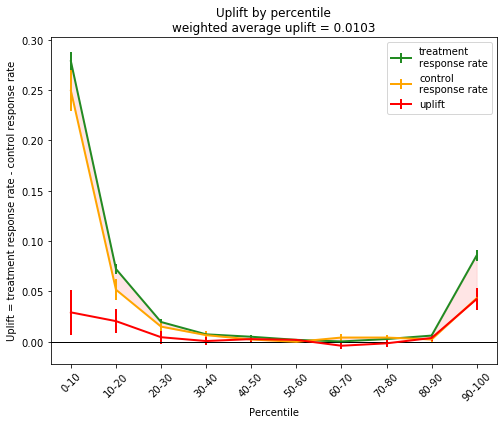

In [36]:
# line plot
plot_uplift_by_percentile(
    X_val[target], 
    scores, 
    X_val[treatment],
    strategy='overall', 
    kind='line');

# 5. SoloModel - solo_classtrans

## 5.1 Считаем важности uplift модели

In [37]:
model = AutoTrees(
    main_estimator=xgb_model, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns,
    
    X_train=X_train[num_columns],
    y_train=X_train[target],
    treatment=X_train[treatment],
    
    model_type='xgboost',
    main_metric='gini',
    uplift='solo_classtrans')

In [38]:
model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[0]	validation_0-logloss:0.68886	validation_0-aucpr:0.31697	validation_0-auc:0.59984	validation_1-logloss:0.68893	validation_1-aucpr:0.29788	validation_1-auc:0.59669
[50]	validation_0-logloss:0.55151	validation_0-aucpr:0.34341	validation_0-auc:0.62033	validation_1-logloss:0.55462	validation_1-aucpr:0.30166	validation_1-auc:0.59522
[100]	validation_0-logloss:0.49426	validation_0-aucpr:0.34971	validation_0-auc:0.62708	validation_1-logloss:0.49977	validation_1-aucpr:0.30307	validation_1-auc:0.59631
[150]	validation_0-logloss:0.46922	validation_0-aucpr:0.35531	validation_0-auc:0.63281	validation_1-logloss:0.47680	validation_1-aucpr:0.30316	validation_1-auc:0.59600
[200]	validation_0-logloss:0.45808	validation_0-aucpr:0.36051	validation_0-auc:0.63818	validation_1-logloss:0.46755	validation_1-aucpr:0.30289	validation_1-auc:0.59572
[202]	validation_0-logloss:0.45779	validation_0-aucpr:0.36070	validation_0-auc:0.63831	validation_1-log

1it [00:06,  6.22s/it]

gini на обучающей выборке: 20.985
gini на проверочной выборке: 19.410

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[0]	validation_0-logloss:0.68889	validation_0-aucpr:0.32105	validation_0-auc:0.60075	validation_1-logloss:0.68886	validation_1-aucpr:0.29321	validation_1-auc:0.59184
[50]	validation_0-logloss:0.55269	validation_0-aucpr:0.34319	validation_0-auc:0.61690	validation_1-logloss:0.55192	validation_1-aucpr:0.30118	validation_1-auc:0.59624
[100]	validation_0-logloss:0.49599	validation_0-aucpr:0.34894	validation_0-auc:0.62382	validation_1-logloss:0.49525	validation_1-aucpr:0.30132	validation_1-auc:0.59527
[150]	validation_0-logloss:0.47128	validation_0-aucpr:0.35371	validation_0-auc:0.62907	validation_1-logloss:0.47107	validation_1-aucpr:0.30095	validation_1-auc:0.59407
[200]	validation_0-logloss:0.46022	validation_0-aucpr:0.35927	validation_0-auc:0.63534	validation_1-logloss:0.46083	validation_1-

2it [00:12,  6.18s/it]

gini на обучающей выборке: 22.390
gini на проверочной выборке: 19.523

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[0]	validation_0-logloss:0.68885	validation_0-aucpr:0.32132	validation_0-auc:0.60542	validation_1-logloss:0.68896	validation_1-aucpr:0.28689	validation_1-auc:0.58256
[50]	validation_0-logloss:0.55099	validation_0-aucpr:0.34297	validation_0-auc:0.61931	validation_1-logloss:0.55534	validation_1-aucpr:0.29899	validation_1-auc:0.58922
[100]	validation_0-logloss:0.49354	validation_0-aucpr:0.34896	validation_0-auc:0.62481	validation_1-logloss:0.50116	validation_1-aucpr:0.29989	validation_1-auc:0.58798
[150]	validation_0-logloss:0.46848	validation_0-aucpr:0.35397	validation_0-auc:0.63028	validation_1-logloss:0.47886	validation_1-aucpr:0.29942	validation_1-auc:0.58825
[200]	validation_0-logloss:0.45724	validation_0-aucpr:0.35925	validation_0-auc:0.63525	validation_1-logloss:0.46992	validation_1-

3it [00:24,  8.89s/it]

BEST ITERATION:  200
gini на обучающей выборке: 27.031
gini на проверочной выборке: 17.918

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[0]	validation_0-logloss:0.68885	validation_0-aucpr:0.31576	validation_0-auc:0.59835	validation_1-logloss:0.68890	validation_1-aucpr:0.30454	validation_1-auc:0.59968
[50]	validation_0-logloss:0.55166	validation_0-aucpr:0.33993	validation_0-auc:0.61499	validation_1-logloss:0.55390	validation_1-aucpr:0.31686	validation_1-auc:0.60204
[100]	validation_0-logloss:0.49452	validation_0-aucpr:0.34609	validation_0-auc:0.62114	validation_1-logloss:0.49872	validation_1-aucpr:0.31701	validation_1-auc:0.60245
[150]	validation_0-logloss:0.46960	validation_0-aucpr:0.35147	validation_0-auc:0.62702	validation_1-logloss:0.47549	validation_1-aucpr:0.31785	validation_1-auc:0.60356
[200]	validation_0-logloss:0.45849	validation_0-aucpr:0.35686	validation_0-auc:0.63349	validation_1-logloss:

4it [00:30,  7.91s/it]

gini на обучающей выборке: 21.956
gini на проверочной выборке: 20.882

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[0]	validation_0-logloss:0.68888	validation_0-aucpr:0.31764	validation_0-auc:0.59876	validation_1-logloss:0.68891	validation_1-aucpr:0.29628	validation_1-auc:0.58679
[50]	validation_0-logloss:0.55196	validation_0-aucpr:0.34325	validation_0-auc:0.61921	validation_1-logloss:0.55324	validation_1-aucpr:0.30917	validation_1-auc:0.59580
[100]	validation_0-logloss:0.49488	validation_0-aucpr:0.34859	validation_0-auc:0.62629	validation_1-logloss:0.49745	validation_1-aucpr:0.31046	validation_1-auc:0.59596
[150]	validation_0-logloss:0.46995	validation_0-aucpr:0.35432	validation_0-auc:0.63401	validation_1-logloss:0.47410	validation_1-aucpr:0.30977	validation_1-auc:0.59522
[200]	validation_0-logloss:0.45878	validation_0-aucpr:0.35999	validation_0-auc:0.63998	validation_1-logloss:0.46441	validation_1-

5it [00:38,  7.61s/it]

gini на обучающей выборке: 23.121
gini на проверочной выборке: 19.545

********************** 5 фолд обучен! ******************************




In [39]:
model.get_mean_cv_scores()

19.455450832873648

In [40]:
model._best_iters

[2, 8, 200, 10, 33]

In [41]:
model.get_extra_scores()

names     fold_1     fold_2     fold_3     fold_4     fold_5
0   roc_train   0.604925   0.611952   0.635153   0.609781   0.615603
1   roc_valid   0.597051   0.597614   0.589590   0.604408   0.597723
2  gini_train  20.984983  22.390450  27.030657  21.956285  23.120588
3  gini_valid  19.410181  19.522779  17.918078  20.881696  19.544520

In [42]:
fi = model.get_fi()
fi

index  importance 0  importance 1  importance 2  importance 3  \
0     f8     29.585083     28.535307     15.813518     27.860319   
1     f9     22.313536     24.273039     21.978745     18.382721   
2     f2      8.971723      8.381814      6.510867      9.044321   
3     f4      5.184041      5.845144      3.998583      6.016362   
4    f10      4.401904      4.674158      3.718577      3.935519   
5     f6      4.127423      4.167709      3.801058      3.882838   
6    f11      4.154206      4.008254      3.707622      3.907610   
7     f1      4.147325      3.916448      3.543680      3.752969   
8     f3      3.868236      3.905082      3.672356      3.716305   
9     f0      3.789453      3.908837      3.671305      3.816181   
10    f7      3.860718      3.938790      3.749111      3.675792   
11    f5      3.508954      3.686526      2.983051      2.945542   

    importance 4  mean_importance  
0      22.165638        24.791973  
1      28.860361        23.161680  
2       7.144332         8.010611  
3       3.913887         4.991603  
4       4.572122         4.260456  
5       4.225944         4.040995  
6       4.121196         3.979778  
7       3.785850         3.829254  
8       3.939093         3.820214  
9       3.818494         3.800854  
10      3.765836         3.798049  
11      3.006489         3.226112

In [43]:
model.get_curve_plots()

## 5.2 Построим модель с подобранными итерациями

In [44]:
params = {
    'eta':0.01*2,
    'n_estimators':round(np.mean(model._best_iters)/0.85),
    'subsample':0.8,
    'colsample_bytree':0.8,
    'max_depth':6,
    'objective':'binary:logistic',
    'use_label_encoder':False,
    'n_jobs':-1,
    'random_state':42}

estimator = xgb.XGBClassifier(**params)
slearner = ClassTransformation(estimator)

In [45]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    kind='num')

prep_pipe.fit(X_train[num_columns], X_train[target])

new_X_train = prep_pipe.transform(X_train[num_columns])
new_X_val = prep_pipe.transform(X_val[num_columns])

In [46]:
slearner = slearner.fit(new_X_train, X_train[target], X_train[treatment])

scores = slearner.predict(new_X_val)

[13:19:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## 4.3 Результат на тесте

In [47]:
uplift_by_percentile(
    X_val[target], 
    scores, 
    X_val[treatment], 
    strategy='overall', 
    total=True, 
    std=True, 
    bins=10)

n_treatment  n_control  response_rate_treatment  \
percentile                                                    
0-10               2590        410                 0.355985   
10-20              2513        487                 0.058894   
20-30              2559        441                 0.021493   
30-40              2534        466                 0.012234   
40-50              2565        435                 0.010916   
50-60              2531        469                 0.004741   
60-70              2540        460                 0.001575   
70-80              2532        468                 0.000790   
80-90              2562        438                 0.001952   
90-100             2576        424                 0.007764   
total             25502       4498                 0.048114   

            response_rate_control    uplift  std_treatment  std_control  \
percentile                                                                
0-10                     0.324390  0.031594       0.009408     0.023120   
10-20                    0.043121  0.015773       0.004696     0.009205   
20-30                    0.020408  0.001085       0.002867     0.006733   
30-40                    0.008584  0.003650       0.002184     0.004273   
40-50                    0.000000  0.010916       0.002052     0.000000   
50-60                    0.000000  0.004741       0.001365     0.000000   
60-70                    0.000000  0.001575       0.000787     0.000000   
70-80                    0.004274 -0.003484       0.000558     0.003015   
80-90                    0.000000  0.001952       0.000872     0.000000   
90-100                   0.002358  0.005405       0.001729     0.002356   
total                    0.037795  0.010319       0.026519     0.048702   

            std_uplift  
percentile              
0-10          0.024961  
10-20         0.010334  
20-30         0.007318  
30-40         0.004799  
40-50         0.002052  
50-60         0.001365  
60-70         0.000787  
70-80         0.003067  
80-90         0.000872  
90-100        0.002922  
total         0.058476

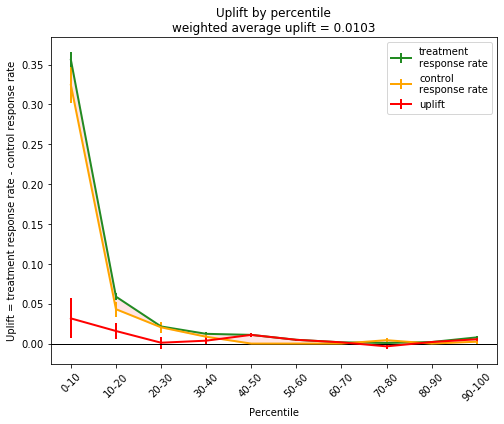

In [48]:
# line plot
plot_uplift_by_percentile(
    X_val[target], 
    scores, 
    X_val[treatment],
    strategy='overall', 
    kind='line');